In [3]:
import json
import folium
import pandas
import MySQLdb

from collections import Counter

from math import sqrt
import numpy as np
from scipy.misc import imread
from shapely.geometry import shape, Point
from vincenty import vincenty

%matplotlib notebook
from matplotlib import pyplot as plt

from skimage.morphology import binary_closing
from skimage.measure import find_contours, label
from jupyter_progressbar import ProgressBar

db = MySQLdb.connect(user='root', passwd='Nmmxhjgt1@', db='stimmen', charset='utf8')

In [4]:
im = imread('dialects.png')

/home/herbert/.virtualenvs/stimmenfryslan/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  """Entry point for launching an IPython kernel.


In [5]:
colors = Counter(map(tuple, im.reshape(-1,3)))

In [6]:
sorted_colors = [c for c, _ in sorted(colors.items(), key=lambda x: x[1], reverse=True)]

In [7]:
blocks = [
    np.ones((10,10,1)) * np.array(c)[None,None] 
    for c in sorted_colors
][:49]

In [8]:
a, w = len(blocks), int(sqrt(len(blocks)))

composed_49 = np.concatenate([
    np.concatenate([
        b
        for b in blocks[a:b]
    ], axis=1)
    for a, b in zip(range(0, a, w), range(w, a, w))
], axis=0)

relevant_colors = np.array([sorted_colors[b] for b in [3,4,7,8]])
regions = ['Klaaifrysk', 'Waldfrysk', 'Sudwesthoeksk', 'Noardhoeksk']

composed_4 = np.concatenate([
    blocks[b] for b in [3,4,7,8]
], axis=1)

In [50]:
print(geojson)

{"type": "FeatureCollection", "features": [{"type": "Feature", "properties": {"dialect": "Klaaifrysk"}, "geometry": {"type": "Polygon", "coordinates": [[[5.794012015464746, 52.912342273640135], [5.791698705528585, 52.912342273640135], [5.789385395592423, 52.912342273640135], [5.787072085656261, 52.912342273640135], [5.78591543068818, 52.9130252649636], [5.784758775720099, 52.913708256287066], [5.783602120752018, 52.91439124761054], [5.783602120752018, 52.91575723025747], [5.783602120752018, 52.9171232129044], [5.782445465783937, 52.91780620422787], [5.781288810815856, 52.91848919555134], [5.781288810815856, 52.91985517819827], [5.780132155847776, 52.920538169521734], [5.778975500879694, 52.92122116084521], [5.778975500879694, 52.92258714349214], [5.7778188459116135, 52.9232701348156], [5.776662190943533, 52.923953126139075], [5.776662190943533, 52.925319108786006], [5.7755055359754515, 52.92600210010947], [5.774348881007371, 52.92668509143294], [5.77319222603929, 52.92736808275641], [5

<IPython.core.display.Javascript object>


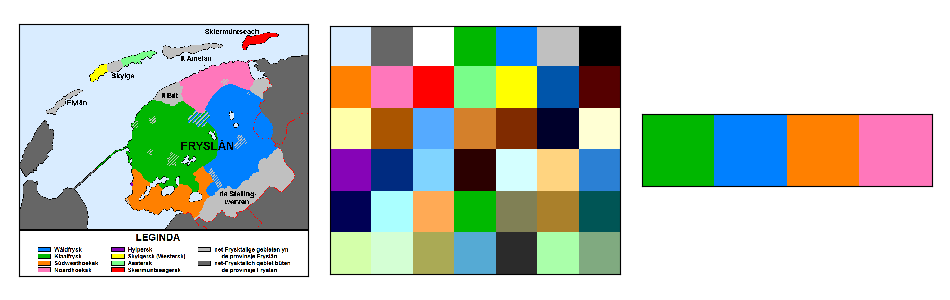

In [9]:
plt.rcParams['figure.figsize'] = (9.5, 3)
ax0, ax1, ax2 = plt.subplots(1,3)[1]
ax0.imshow(im)
ax1.imshow(composed_49.astype(int))
ax2.imshow(composed_4.astype(int))
ax0.set_xticks([]); ax0.set_yticks([])
ax1.set_xticks([]); ax1.set_yticks([])
ax2.set_xticks([]); ax2.set_yticks([])
plt.tight_layout()

stavoren_to_east_coords = [5.354483127593994, 6.330699920654297]
north_to_south_coords = [53.41434089638827, 52.832432288794514]

stavoren_to_east_pixels = [295, 717]
north_to_south_pixels = [99, 525]

<IPython.core.display.Javascript object>


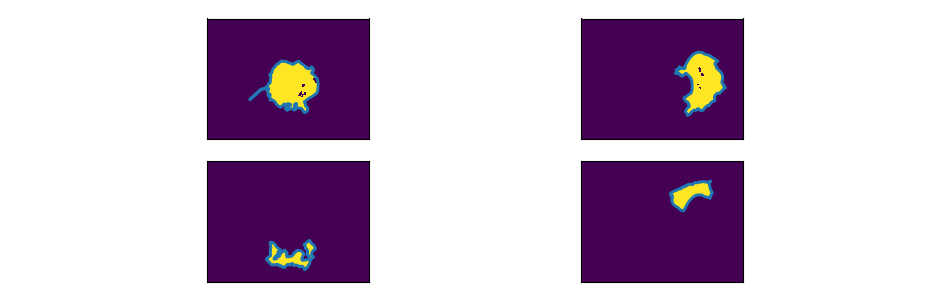

In [12]:
axes = plt.subplots(2,2)[1].ravel()
contours = []
for axis, c in zip(axes, relevant_colors):
    bi = (im[:-100] == c[None,None]).min(axis=2)
    bi = binary_closing(bi, np.ones((5,5)))
    
    labels = label(bi, background=False)
    
    contours.append(find_contours(bi, 0.5))

    axis.imshow(bi)
    for n, contour in enumerate(contours[-1][:1]):
        axis.plot(contour[:, 1], contour[:, 0], linewidth=2)
        axis.set_xticks([]); axis.set_yticks([])
plt.tight_layout()

In [13]:
a0, b0 = stavoren_to_east_coords
c0, d0 = stavoren_to_east_pixels

scale_x = lambda x: (x - c0) / (d0 - c0) * (b0 - a0) + a0

a1, b1 = north_to_south_coords
c1, d1 = north_to_south_pixels

scale_y = lambda x: (x - c1) / (d1 - c1) * (b1 - a1) + a1

contours_scaled = [
    list(zip(scale_x(c[0][:, 1]), scale_y(c[0][:, 0])))
    for c in contours
]

In [14]:
geojson = json.dumps({
  "type": "FeatureCollection",
  "features": [
    {
      "type": "Feature",
      "properties": {'dialect': dialect},
      "geometry": {
        "type": "Polygon",
        "coordinates": [list(map(list, contour))]
      }
    }
    for contour, dialect in zip(contours_scaled, regions)
  ]
})

with open('dialect_regions.geojson', 'w') as f:
    f.write(geojson)

In [15]:
m = folium.Map(
    location=[sum(north_to_south_coords) / 2, sum(stavoren_to_east_coords) / 2],
    tiles='Mapbox Bright',
    zoom_start=9
)
folium.GeoJson('dialect_regions.geojson', name='geojson').add_to(m)

m

In [18]:
shapes = {
    dialect: shape({"type": "Polygon", "coordinates": [list(map(list, contour))]})
    for contour, dialect in zip(contours_scaled, regions)
}

def regions_for(coordinate):
    regions = {
        region_name
        for region_name, shape in shapes.items()
        if shape.contains(Point(*coordinate))
    }
    return regions

def distance(shape, longitude, latitude):
    ext = shape.exterior
    p = ext.interpolate(ext.project(Point(longitude, latitude)))
    return vincenty((latitude, longitude), (p.y, p.x))

In [38]:
# SELECT user_lat, user_lng, question_text, answer_text
picture_games = pandas.read_sql('''
SELECT language.name as language, item.name as picture,
       survey.user_lat as latitude, survey.user_lng as longitude,
       survey.area_name as area, survey.country_name as country,
       result.recording as filename,
       result.submitted_at as date
FROM       core_surveyresult as survey
INNER JOIN core_picturegameresult as result ON survey.id = result.survey_result_id
INNER JOIN core_language as language ON language.id = result.language_id
INNER JOIN core_picturegameitem as item
    ON result.picture_game_item_id = item.id
''', db)
# picture_games['filename'] = [filename.split('/')[-1] for filename in picture_games['filename']]
picture_games.set_index('filename', inplace=True)

In [40]:
region_per_picture_game = [
    {
        'dialects': [
            {
                'dialect': dialect,
                'boundary_distance': distance(shapes[dialect], longitude, latitude),
            }
            for dialect in regions_for((longitude, latitude))
        ],
        'filename': filename,
    }
    for filename, (latitude, longitude) in ProgressBar(
        picture_games[['latitude', 'longitude']].iterrows(),
        size=len(picture_games)
    )
]

In [27]:
Counter(len(x['dialects']) for x in region_per_picture_game)

Counter({1: 37681, 0: 6790, 2: 1235})

In [49]:
df = pandas.DataFrame([
    [r['filename'], r['dialects'][0]['dialect'], r['dialects'][0]['boundary_distance']]
    for r in region_per_picture_game
    if len(r['dialects']) == 1
], columns = ['filename', 'dialect', 'boundary_distance'])

df.to_excel('picture_game_recordings_by_dialect.xlsx')
df.to_csv('picture_game_recordings_by_dialect.csv')
df

filename        dialect  \
0      picture_game_recordings/Frysk/2017-07-05/pg_sc...      Waldfrysk   
1      picture_game_recordings/Frysk/2017-07-05/pg_sc...      Waldfrysk   
2      picture_game_recordings/Nederlands/2017-07-05/...      Waldfrysk   
3      picture_game_recordings/Frysk/2017-07-05/pg_sc...      Waldfrysk   
4      picture_game_recordings/Frysk/2017-07-05/pg_sc...    Noardhoeksk   
5      picture_game_recordings/Frysk/2017-07-05/pg_sc...      Waldfrysk   
6      picture_game_recordings/Frysk/2017-07-05/pg_sc...      Waldfrysk   
7      picture_game_recordings/English/2017-07-05/pg_...      Waldfrysk   
8      picture_game_recordings/Frysk/2017-07-05/pg_sc...      Waldfrysk   
9      picture_game_recordings/Frysk/2017-07-05/pg_sc...      Waldfrysk   
10     picture_game_recordings/Nederlands/2017-07-05/...    Noardhoeksk   
11     picture_game_recordings/Frysk/2017-07-05/pg_sc...      Waldfrysk   
12     picture_game_recordings/Frysk/2017-07-05/pg_sc...      Waldfrysk   
13     picture_game_recordings/Frysk/2017-07-05/pg_sc...      Waldfrysk   
14     picture_game_recordings/Frysk/2017-07-05/pg_sc...      Waldfrysk   
15     picture_game_recordings/Frysk/2017-07-05/pg_sc...      Waldfrysk   
16     picture_game_recordings/Frysk/2017-07-05/pg_sc...      Waldfrysk   
17     picture_game_recordings/Frysk/2017-07-05/pg_sc...      Waldfrysk   
18     picture_game_recordings/Frysk/2017-07-05/pg_sc...      Waldfrysk   
19     picture_game_recordings/Frysk/2017-07-05/pg_sc...      Waldfrysk   
20     picture_game_recordings/Frysk/2017-07-05/pg_sc...      Waldfrysk   
21     picture_game_recordings/Frysk/2017-07-05/pg_sc...      Waldfrysk   
22     picture_game_recordings/Frysk/2017-07-05/pg_sc...      Waldfrysk   
23     picture_game_recordings/Frysk/2017-07-05/pg_sc...      Waldfrysk   
24     picture_game_recordings/Frysk/2017-07-05/pg_sc...      Waldfrysk   
25     picture_game_recordings/Frysk/2017-07-05/pg_sc...      Waldfrysk   
26     picture_game_recordings/Nederlands/2017-07-05/...      Waldfrysk   
27     picture_game_recordings/Nederlands/2017-07-05/...      Waldfrysk   
28     picture_game_recordings/Nederlands/2017-07-05/...      Waldfrysk   
29     picture_game_recordings/Frysk/2017-07-05/pg_sc...      Waldfrysk   
...                                                  ...            ...   
37651  picture_game_recordings/Frysk/2018-03-11/pg_gi...    Noardhoeksk   
37652  picture_game_recordings/Frysk/2018-04-07/pg_gi...      Waldfrysk   
37653  picture_game_recordings/Frysk/2018-04-07/pg_gi...      Waldfrysk   
37654  picture_game_recordings/Stadsfrys/2018-04-08/p...     Klaaifrysk   
37655  picture_game_recordings/Nederlands/2018-04-09/...      Waldfrysk   
37656  picture_game_recordings/Frysk/2018-04-11/pg_gi...     Klaaifrysk   
37657  picture_game_recordings/Frysk/2018-04-20/pg_gi...    Noardhoeksk   
37658  picture_game_recordings/Frysk/2018-04-21/pg_gi...     Klaaifrysk   
37659  picture_game_recordings/Frysk/2018-04-21/pg_gi...      Waldfrysk   
37660  picture_game_recordings/Frysk/2018-04-21/pg_gi...  Sudwesthoeksk   
37661  picture_game_recordings/Frysk/2018-04-21/pg_gi...     Klaaifrysk   
37662  picture_game_recordings/Frysk/2018-04-21/pg_gi...      Waldfrysk   
37663  picture_game_recordings/Frysk/2018-04-22/pg_gi...      Waldfrysk   
37664  picture_game_recordings/Frysk/2018-04-22/pg_gi...  Sudwesthoeksk   
37665  picture_game_recordings/Stadsfrys/2018-04-22/p...     Klaaifrysk   
37666  picture_game_recordings/Frysk/2018-04-22/pg_gi...     Klaaifrysk   
37667  picture_game_recordings/Stadsfrys/2018-04-24/p...     Klaaifrysk   
37668  picture_game_recordings/Frysk/2018-04-24/pg_gi...     Klaaifrysk   
37669  picture_game_recordings/Frysk/2018-04-25/pg_gi...      Waldfrysk   
37670  picture_game_recordings/Frysk/2018-04-28/pg_gi...     Klaaifrysk   
37671  picture_game_recordings/Frysk/2018-04-28/pg_gi...     Klaaifrysk   
37672  picture_game_recordings/Frysk/2018-04-28/pg_gi...      Waldfrysk  

In [41]:
# SELECT user_lat, user_lng, question_text, answer_text
free_speech_games = pandas.read_sql('''
SELECT language.name as language,
       survey.user_lat as latitude, survey.user_lng as longitude,
       survey.area_name as area, survey.country_name as country,
       result.recording as filename,
       result.submitted_at as date
FROM       core_surveyresult as survey
INNER JOIN core_freespeechresult as result ON survey.id = result.survey_result_id
INNER JOIN core_language as language ON language.id = result.language_id
''', db)
# free_speech_games['filename'] = [filename.split('/')[-1] for filename in games['filename']]
free_speech_games.set_index('filename', inplace=True)

In [42]:
region_per_free_speech = [
    {
        'dialects': [
            {
                'dialect': dialect,
                'boundary_distance': distance(shapes[dialect], longitude, latitude),
            }
            for dialect in regions_for((longitude, latitude))
        ],
        'filename': filename,
    }
    for filename, (latitude, longitude) in ProgressBar(
        free_speech_games[['latitude', 'longitude']].iterrows(),
        size=len(free_speech_games)
    )
]

In [43]:
Counter(len(x['dialects']) for x in region_per_free_speech)

Counter({1: 37681, 0: 6790, 2: 1235})

In [48]:
df = pandas.DataFrame([
    [r['filename'], r['dialects'][0]['dialect'], r['dialects'][0]['boundary_distance']]
    for r in region_per_free_speech
    if len(r['dialects']) == 1
], columns = ['filename', 'dialect', 'boundary_distance'])

df.to_excel('free_speech_recordings_by_dialect.xlsx')
df.to_csv('free_speech_recordings_by_dialect.csv')
df

filename      dialect  \
0    free_speech_recordings/Frysk/2017-07-05/fs_wha...    Waldfrysk   
1    free_speech_recordings/Nederlands/2017-07-05/f...    Waldfrysk   
2    free_speech_recordings/Frysk/2017-07-05/fs_wha...    Waldfrysk   
3    free_speech_recordings/Frysk/2017-07-05/fs_wha...    Waldfrysk   
4    free_speech_recordings/Frysk/2017-07-05/fs_jok...    Waldfrysk   
5    free_speech_recordings/Frysk/2017-07-05/fs_jok...    Waldfrysk   
6    free_speech_recordings/Frysk/2017-07-05/fs_jok...    Waldfrysk   
7    free_speech_recordings/Frysk/2017-07-05/fs_you...    Waldfrysk   
8    free_speech_recordings/Frysk/2017-07-05/fs_jok...    Waldfrysk   
9    free_speech_recordings/Frysk/2017-07-05/fs_wha...    Waldfrysk   
10   free_speech_recordings/Frysk/2017-07-05/fs_wha...    Waldfrysk   
11   free_speech_recordings/Frysk/2017-07-05/fs_gro...    Waldfrysk   
12   free_speech_recordings/English/2017-07-05/fs_w...    Waldfrysk   
13   free_speech_recordings/Frysk/2017-07-05/fs_wha...    Waldfrysk   
14   free_speech_recordings/Nederlands/2017-07-05/f...    Waldfrysk   
15   free_speech_recordings/Frysk/2017-07-05/fs_wha...    Waldfrysk   
16   free_speech_recordings/Nederlands/2017-07-05/f...    Waldfrysk   
17   free_speech_recordings/Frysk/2017-07-05/fs_wha...    Waldfrysk   
18   free_speech_recordings/Frysk/2017-07-05/fs_gro...    Waldfrysk   
19   free_speech_recordings/Frysk/2017-07-05/fs_jok...    Waldfrysk   
20   free_speech_recordings/English/2017-07-05/fs_w...    Waldfrysk   
21   free_speech_recordings/Frysk/2017-07-05/fs_you...    Waldfrysk   
22   free_speech_recordings/Frysk/2017-07-05/fs_wha...    Waldfrysk   
23   free_speech_recordings/Nederlands/2017-07-05/f...    Waldfrysk   
24   free_speech_recordings/Frysk/2017-07-05/fs_jok...    Waldfrysk   
25   free_speech_recordings/Nederlands/2017-07-05/f...    Waldfrysk   
26   free_speech_recordings/Frysk/2017-07-05/fs_gro...    Waldfrysk   
27   free_speech_recordings/Frysk/2017-07-05/fs_rea...    Waldfrysk   
28   free_speech_recordings/Frysk/2017-07-05/fs_wha...    Waldfrysk   
29   free_speech_recordings/Nederlands/2017-07-05/f...    Waldfrysk   
..                                                 ...          ...   
282  free_speech_recordings/Frysk/2017-11-29/fs_fav...    Waldfrysk   
283  free_speech_recordings/Frysk/2017-12-01/fs_wha...    Waldfrysk   
284  free_speech_recordings/Frysk/2017-12-08/fs_wha...    Waldfrysk   
285  free_speech_recordings/Frysk/2017-12-08/fs_wha...    Waldfrysk   
286  free_speech_recordings/Frysk/2017-12-08/fs_wha...    Waldfrysk   
287  free_speech_recordings/Frysk/2017-12-08/fs_wha...    Waldfrysk   
288  free_speech_recordings/Frysk/2017-12-08/fs_jok...    Waldfrysk   
289  free_speech_recordings/Frysk/2017-12-09/fs_gro...    Waldfrysk   
290  free_speech_recordings/Frysk/2017-12-11/fs_wha...   Klaaifrysk   
291  free_speech_recordings/Nederlands/2017-12-12/f...   Klaaifrysk   
292  free_speech_recordings/Frysk/2017-12-12/fs_wha...   Klaaifrysk   
293  free_speech_recordings/Frysk/2017-12-13/fs_jok...    Waldfrysk   
294  free_speech_recordings/Frysk/2017-12-14/fs_wha...   Klaaifrysk   
295  free_speech_recordings/Frysk/2017-12-14/fs_you...   Klaaifrysk   
296  free_speech_recordings/Frysk/2017-12-14/fs_you...   Klaaifrysk   
297  free_speech_recordings/Frysk/2017-12-14/fs_jok...   Klaaifrysk   
298  free_speech_recordings/Frysk/2017-12-14/fs_jok...   Klaaifrysk   
299  free_speech_recordings/Frysk/2017-12-19/fs_jok...    Waldfrysk   
300  free_speech_recordings/Frysk/2017-12-19/fs_jok...    Waldfrysk   
301  free_speech_recordings/Frysk/2017-12-20/fs_gro...    Waldfrysk   
302  free_speech_recordings/Frysk/2017-12-20/fs_wha...    Waldfrysk   
303  free_speech_recordings/Frysk/2018-01-20/fs_wha...    Waldfrysk   
304  free_speech_recordings/Nederlands/2018-04-08/f...   Klaaifrysk   
305  free_speech_recordings/Stadsfrys/2018-04-08/fs...   Klaaifrysk   
306  free_speech_recordings/Frysk/2018-04-21/fs_gro...    Waldfrysk   